In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import keras
from keras import layers, models
from tensorflow import data as tf_data
keras.config.set_image_data_format("channels_first")

2025-07-09 17:45:23.873582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752075923.884806   98861 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752075923.888278   98861 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752075923.897167   98861 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752075923.897180   98861 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752075923.897181   98861 computation_placer.cc:177] computation placer alr

In [2]:
@keras.saving.register_keras_serializable()
class FireModule(layers.Layer):
    def __init__(self, squeeze_filters, expand1x1_filters, expand3x3_filters, name=None, **kwargs):
        super(FireModule, self).__init__(name=name, **kwargs)
        self.squeeze_filters = squeeze_filters
        self.expand1x1_filters = expand1x1_filters
        self.expand3x3_filters = expand3x3_filters
        # Define the layers for the Fire module
        self.squeeze = layers.Conv2D(self.squeeze_filters, (1, 1), activation='relu', data_format='channels_first')
        self.expand1x1 = layers.Conv2D(self.expand1x1_filters, (1, 1), activation='relu', data_format='channels_first')
        self.expand3x3 = layers.Conv2D(self.expand3x3_filters, (3, 3), padding='same', activation='relu', data_format='channels_first')

    def call(self, inputs):
        x = self.squeeze(inputs)
        x1 = self.expand1x1(x)
        x2 = self.expand3x3(x)
        #output = tf.concat([x1, x2], axis=1)  # Concatenate along the channel axis
        output = keras.ops.concatenate([x1, x2], axis=1) # Concatenate along the channel axis
        return output
    
    def get_config(self):
        config = super(FireModule, self).get_config()
        config.update(
            {

            "squeeze_filters": self.squeeze_filters,
            "expand1x1_filters": self.expand1x1_filters,
            "expand3x3_filters":self.expand3x3_filters
            }
        )
        return config

    @classmethod
    def from_config(cls, config):
        config['squeeze_filters'] = keras.saving.deserialize_keras_object(config['squeeze_filters'])
        config['expand1x1_filters'] = keras.saving.deserialize_keras_object(config['expand1x1_filters'])
        config['expand3x3_filters'] = keras.saving.deserialize_keras_object(config['expand3x3_filters'])
        return cls(**config)

In [3]:
# Load keras model
model = keras.models.load_model('minisqueezenet_96.keras',
    custom_objects={"FireModule": FireModule})
model.summary()

I0000 00:00:1752075925.992376   98861 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9612 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5
/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'fire_module', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'fire_module_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not b

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3, 96, 96)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 64, 94, 94)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 46, 46)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fire_module (FireModule)        │ (None, 128, 46, 46)    │        11,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fire_module_1 (FireModule)      │ (None, 128, 46, 46)    │        12,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 128, 22, 22)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 22, 22)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 22, 22)      │           258 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,681 (303.45 KB)

 Trainable params: 25,893 (101.14 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 51,788 (202.30 KB)


## Preparing and testing the quantized TFLite model


In [48]:
# Convert the model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpiqy9llx3/assets


INFO:tensorflow:Assets written to: /tmp/tmpiqy9llx3/assets


Saved artifact at '/tmp/tmpiqy9llx3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 96, 96), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135150037478544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103752784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103757584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103757200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103759120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103759696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103760464: 

W0000 00:00:1752076992.711365   98861 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752076992.711375   98861 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-09 18:03:12.711481: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpiqy9llx3
2025-07-09 18:03:12.712128: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-09 18:03:12.712135: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpiqy9llx3
2025-07-09 18:03:12.719185: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-09 18:03:12.755179: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpiqy9llx3
2025-07-09 18:03:12.767208: I tensorflow/cc/saved_model/loader.cc:471] SavedModel load for tags { serve }; Status: success: OK. Took 55729 microseconds.


In [9]:
print(len(tflite_model), "bytes")

111636 bytes


### With optimizations 

In [53]:

# Prepare representative dataset for model quantization.

train_ds = keras.utils.image_dataset_from_directory(
    "./data/human_dataset_a/train",
    seed=1337,
    image_size=(96,96),
    batch_size=1,
    label_mode='binary'    
   
)

# Reescale image values from 0-255 to 0-1
#rescale_fn = layers.Rescaling(1.0 / 255)
#train_ds = train_ds.map(lambda x, y: (rescale_fn(x), y))

#repr_ds = train_ds.unbatch()

def representative_data_gen():
  for i_value, o_value in train_ds.take(64):
    yield [i_value.numpy().astype(np.float32)]
    #yield [i_value]

Found 33280 files belonging to 2 classes.


In [54]:
# Convert keras model to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Provide a representative dataset for calibration
converter.representative_dataset = tf.lite.RepresentativeDataset(representative_data_gen)
# Apply the default optimizations
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Set the target specification to use INT8 operations
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the inference input and output types to INT8
converter.inference_type = tf.int8
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpwgyl22t0/assets


INFO:tensorflow:Assets written to: /tmp/tmpwgyl22t0/assets


Saved artifact at '/tmp/tmpwgyl22t0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 3, 96, 96), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135150037478544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103752784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103757584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103757200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103759120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103759696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103758928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135147103760464: 

/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/tensorflow/lite/python/convert.py:854: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
W0000 00:00:1752077406.548501   98861 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1752077406.548510   98861 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-07-09 18:10:06.548613: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpwgyl22t0
2025-07-09 18:10:06.549259: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-07-09 18:10:06.549265: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpwgyl22t0
2025-07-09 18:10:06.556144: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-07-09 18:10:06.591709: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path:

In [55]:
print(len(tflite_model), "bytes")

44792 bytes


In [60]:
# Save the TFLite model
with open('minisqueezenet_96.tflite', 'wb') as f:
    f.write(tflite_model)

### Initialize the TFLite interpreter

In [ ]:
# Initialize the TFLite interpreter
interpreter = tf.lite.Interpreter(model_content=tflite_model)
#interpreter = tf.lite.Interpreter(model_path='quantized_model.tflite')
# Allocate the tensors
interpreter.allocate_tensors()

/home/pico/miniconda3/envs/torch/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.



### Get input quantization parameters


In [59]:
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Get the details of all tensors in the model
tensor_details = interpreter.get_tensor_details()

# Print details of each tensor
for tensor in tensor_details:
    print(f"Tensor Name: {tensor['name']}, Type: {tensor['dtype']}, Quantization: {tensor['quantization']}")

# Initialize counters
quantized_count = 0
non_quantized_count = 0

# Iterate through tensor details
for tensor in tensor_details:
    tensor_type = tensor['dtype']
    # Check if the tensor is quantized
    if tensor_type == tf.int8:
        quantized_count += tf.reduce_prod(tensor['shape']).numpy()  # Count the number of quantized parameters
    else:
        non_quantized_count += tf.reduce_prod(tensor['shape']).numpy()  # Count the number of non-quantized parameters

# Print the results
print(f'Total quantized parameters: {quantized_count}')
print(f'Total non-quantized parameters: {non_quantized_count}')


Tensor Name: serving_default_input_layer:0, Type: <class 'numpy.int8'>, Quantization: (1.0, -128)
Tensor Name: arith.constant, Type: <class 'numpy.int32'>, Quantization: (0.0, 0)
Tensor Name: arith.constant1, Type: <class 'numpy.int32'>, Quantization: (0.0, 0)
Tensor Name: arith.constant2, Type: <class 'numpy.int32'>, Quantization: (0.0, 0)
Tensor Name: tfl.pseudo_qconst, Type: <class 'numpy.int32'>, Quantization: (0.6157441735267639, 0)
Tensor Name: tfl.pseudo_qconst1, Type: <class 'numpy.int8'>, Quantization: (0.01239998359233141, 0)
Tensor Name: tfl.pseudo_qconst2, Type: <class 'numpy.int32'>, Quantization: (0.0, 0)
Tensor Name: tfl.pseudo_qconst3, Type: <class 'numpy.int8'>, Quantization: (0.0, 0)
Tensor Name: tfl.pseudo_qconst4, Type: <class 'numpy.int32'>, Quantization: (0.0, 0)
Tensor Name: tfl.pseudo_qconst5, Type: <class 'numpy.int8'>, Quantization: (0.0, 0)
Tensor Name: tfl.pseudo_qconst6, Type: <class 'numpy.int32'>, Quantization: (0.0, 0)
Tensor Name: tfl.pseudo_qconst7, Ty

In [74]:
# Prepare the validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    "./data/human_dataset_a/validation",
    seed=1337,
    image_size=(96, 96),
    batch_size=1,
    label_mode="binary"
)

Found 8320 files belonging to 2 classes.


In [81]:
# Initialize lists to store predictions and true labels
all_predictions = []
all_labels = []

# Iterate through the validation dataset
for images, label in val_ds:
    # Convert images to INT8
    image = np.array(images) - 128  # Ensure it's a NumPy array and shift to [-128, 127]
    image = image.astype(np.int8)  # Convert to INT8
    
    # Set the input tensor
    interpreter.set_tensor(input_details[0]['index'], image)
    
    # Run inference
    interpreter.invoke()
    
    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
   
    
    # Convert output to predictions (assuming binary classification)
    #prediction = np.argmax(output_data, axis=1)  # Use argmax for multi-class, or threshold for binary
    prediction = np.array(output_data, dtype=np.float32)  # Convert to float32 for processing
    # Set the value based on the condition
    prediction[0, 0] = 1. if prediction[0, 0] > 0. else 0.
    # Alternatively, using NumPy's where function
    # prediction = np.where(prediction > 0, 1, 0)

    all_predictions.extend(prediction)
    all_labels.extend(label.numpy())

# Convert lists to numpy arrays for metric calculation
all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

# Calculate accuracy
accuracy = np.mean(all_predictions == all_labels)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.7885


### Convert the TFLite model to a C-byte array with xxd

In [84]:
# apt-get install xxd

In [ ]:
#!xxd -c 60 -i minisqueezenet_96.tflite > minisqueezenet_96.h

I0000 00:00:1752060581.818327   79631 service.cc:152] XLA service 0x7e6db8002c00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752060581.818341   79631 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-07-09 13:29:41.982106: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1752060582.237556   79631 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-07-09 13:29:43.666545: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:549] Omitted potentially buggy algorithm eng14{k25=2} for conv %cudnn-conv-bias-activation.24 = (f32[1,64,94,94]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,96,96]{3,2,1,0} %bitcast.331, f32[64,3,3,3]{3,2,1,0} %bitcast.338, f32[64]{0} %bitcast.340), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBias

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
This image is 96.25% human and 3.75% not human.
[[0.03748973]]


I0000 00:00:1752060584.711540   79631 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


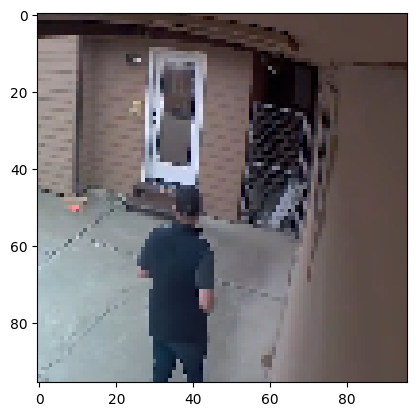

In [5]:
img = keras.utils.load_img(
    "/home/pico/code/esp32cam_human_detector/human_presence_classifier/data/human_dataset_a/test/human/78.png", 
    target_size=(96, 96))

plt.imshow(img)

img_array = keras.utils.img_to_array(img)
# Reescale image values from 0-255 to 0-1
rescale_fn = layers.Rescaling(1.0 / 255)
img_array = rescale_fn(img_array)
# Add batch dimension
img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(f"This image is {100 * (1 - predictions[0][0]):.2f}% human and {100 * predictions[0][0]:.2f}% not human.")
print(predictions)

In [41]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [42]:
import keras
print(keras.__version__)

3.10.0


In [50]:
tflite_model.summary()

AttributeError: 'bytes' object has no attribute 'summary'

In [36]:
u = None
for i in a:
    print(i)
    u = i
    break

[array([[[[ 54.11111  ,  60.333332 ,  63.11111  , ..., 130.88889  ,
          123.       , 102.1112   ],
         [ 56.666668 ,  63.       ,  66.333336 , ..., 130.33334  ,
          124.       , 102.333405 ],
         [ 59.11111  ,  65.333336 ,  68.33333  , ...,  99.88889  ,
           92.333336 ,  94.00002  ],
         ...,
         [ 29.333344 ,  32.       ,  37.222206 , ...,  53.88888  ,
           51.666656 ,  48.666656 ],
         [ 28.666666 ,  31.       ,  35.666664 , ...,  54.       ,
           52.       ,  48.       ],
         [ 29.       ,  32.       ,  35.666664 , ...,  54.111115 ,
           51.33333  ,  48.33333  ]],

        [[ 61.11111  ,  67.333336 ,  72.11111  , ..., 132.88889  ,
          125.       , 104.1112   ],
         [ 63.666668 ,  72.       ,  75.333336 , ..., 134.33334  ,
          126.       , 104.333405 ],
         [ 68.111115 ,  74.333336 ,  77.33333  , ..., 104.88889  ,
           97.33333  ,  99.00002  ],
         ...,
         [ 31.333344 ,  34.      

In [37]:
u

[array([[[[ 54.11111  ,  60.333332 ,  63.11111  , ..., 130.88889  ,
           123.       , 102.1112   ],
          [ 56.666668 ,  63.       ,  66.333336 , ..., 130.33334  ,
           124.       , 102.333405 ],
          [ 59.11111  ,  65.333336 ,  68.33333  , ...,  99.88889  ,
            92.333336 ,  94.00002  ],
          ...,
          [ 29.333344 ,  32.       ,  37.222206 , ...,  53.88888  ,
            51.666656 ,  48.666656 ],
          [ 28.666666 ,  31.       ,  35.666664 , ...,  54.       ,
            52.       ,  48.       ],
          [ 29.       ,  32.       ,  35.666664 , ...,  54.111115 ,
            51.33333  ,  48.33333  ]],
 
         [[ 61.11111  ,  67.333336 ,  72.11111  , ..., 132.88889  ,
           125.       , 104.1112   ],
          [ 63.666668 ,  72.       ,  75.333336 , ..., 134.33334  ,
           126.       , 104.333405 ],
          [ 68.111115 ,  74.333336 ,  77.33333  , ..., 104.88889  ,
            97.33333  ,  99.00002  ],
          ...,
          [ 3

In [38]:
type(u)

list

In [39]:
len(u)

1

In [40]:
u = u[0]

In [35]:
u.shape

(1, 3, 96, 96)